In [140]:
using Flux
using Flux: @epochs, throttle
using ExprOptimization
using Base.Iterators: repeated
using BSON: @save
using BSON: @load
using Plots

In [168]:
function plotLoss(lossVals)
    floatLossVals = [Tracker.data(lv) for lv in lossVals]
    gr(fmt=:png)
    plot()
    plot!(floatLossVals,
        xlabel = "time",
        ylabel = "loss",
        label = "loss",
        title = "loss evolution")
end

plotLoss (generic function with 1 method)

In [163]:
# learn simple function that is 0 if x=0 and 1 if x>0
input_size = 3
output_size = 1
X = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
Y = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]
model = Chain(Dense(input_size,128, relu), Dense(128,output_size, relu)) 
loss(x, y) = Flux.mse(model(x), y)
# data = [(X,Y)]
data = repeated((X, Y), 1000)
opt = Flux.Optimise.ADAM()
lossVals = [loss(X,Y)]
evalcb = () -> begin curLoss = loss(X,Y)
    push!(lossVals, curLoss)
    @show(curLoss) end
evalcb2 = () -> @save "model-flux.bson" model

# evalcb = @show(loss(X, Y))
# throttle(30) do
#   # Show loss
#     @show "hi there"
# #   @save "model-checkpoint.bson" model
# end

#179 (generic function with 1 method)

In [164]:
@show loss(X,Y)

loss(X, Y) = 0.5915178126861305 (tracked)


0.5915178126861305 (tracked)

In [165]:
# @epochs 2 Flux.train!(loss, params(model), data, opt, cb = throttle(evalcb, 30))
@epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30), throttle(evalcb2, 60)])

curLoss = 0.5084311997205263 (tracked)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 2.9132252166164105e-14 (tracked)


┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 8.526512829121202e-15 (tracked)


┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 1.4210854715202005e-15 (tracked)


┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.0 (tracked)


┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.0 (tracked)


┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.0 (tracked)


┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.0 (tracked)


┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.0 (tracked)


┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.0 (tracked)


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


lossVals = Tracker.TrackedReal{Float64}[0.591518, 0.508431, 2.91323e-14, 8.52651e-15, 1.42109e-15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


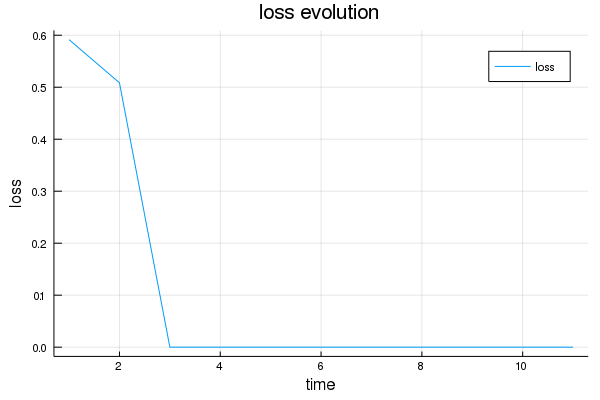

In [169]:
@show lossVals
plotLoss(lossVals)

In [118]:
@show model(ones(3,1))
@show model(3*ones(3,1))
@show model(5*ones(3,1))
@show model(zeros(3,1))

model(ones(3, 1)) = Float32[1.0] (tracked)
model(3 * ones(3, 1)) = Float32[1.0] (tracked)
model(5 * ones(3, 1)) = Float32[1.02699] (tracked)
model(zeros(3, 1)) = Float32[0.0] (tracked)


Tracked 1×1 Array{Float32,2}:
 0.0f0

In [30]:
@grammar begin
model = Chain(layer, layer, layer, layer, relu) | Chain(layer, layer, layer, layer, layer, relu)
layer = Dense(n, activation)
n = 128|256|512|1024
activation = relu
end

1: model = Chain(layer, layer, layer, layer, relu)
2: model = Chain(layer, layer, layer, layer, layer, relu)
3: layer = Dense(n, activation)
4: n = 128
5: n = 256
6: n = 512
7: n = 1024
8: activation = relu


In [1]:
@grammar begin
model = Chain(layer, layer, relu) | Chain(layer, layer, layer, relu)
layer = Dense(n, activation) | OtherLayerType(...)
n = |(50:50:500)
activation = relu | tanh
end

LoadError: syntax: invalid identifier name "..."

In [ ]:
model2 = Chain(
  Dense(10, 5, σ),
  Dense(5, 2),
  softmax)

In [19]:
imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

UndefVarError: UndefVarError: MNIST not defined

In [ ]:
# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)
